In [499]:
import numpy as np
import pandas as pd
import sqlite3
import json
from datetime import datetime, timedelta
from collections import namedtuple
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin


pd.set_option('display.max_columns', None)

In [512]:
DB_PATH = '/Users/ezras/projects/personal/finance_ml/data/quarterly_financial_data.db'
INFO_CSV_PATH = '/Users/ezras/projects/personal/finance_ml/data/stock_general_info.csv'
TABLE_NAME = 'yahoo_financial_data'
STOCKPUP_TABLE_NAME = 'stockpup_data'


DELTA_PREFIX = 'Delta_'
VS_MKT_IDX = '_vs_'
AVG_REC_SCORE_PREFIX = 'AvgRecScore_'

MISSING_SECTOR = 'MissingSector'
MISSING_INDUSTRY = 'MissingIndustry'

MONTH_TO_QUARTER = {
    1: 4,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 2,
    8: 3,
    9: 3,
    10: 3,
    11: 4,
    12: 4
}
    

class StockPupColumns:
    """
    Our dataset comes from over 20 years of 10-Q and 10-K filings made by public companies
     with the U.S. Securities and Exchange Commission. We extract data from both text and
     XBRL filings, fix reporting mistakes, and normalize the data into quarterly time series
     of final restated values.
    """
    # Date Quarter Ends
    QUARTER_END = 'QuarterEnd'
    # The total number of common shares outstanding at the end of a given quarter, including all
    # classes of common stock.
    SHARES = 'Shares'
    # The number of shares the company had at the end of a given quarter, adjusted for splits to
    # be comparable to today's shares.
    SHARES_SPLIT_ADJUSTED = 'SharesSplitAdjusted'
    # If an investor started with 1 share of stock at the end of a given quarter, the split factor
    # for that quarter indicates how many shares the investor would own today as a result of
    # subsequent stock splits.
    SPLIT_FACTOR = 'SplitFactor'
    # Total assets at the end of a quarter.
    ASSETS = 'Assets'
    # Current assets at the end of a quarter.
    CURRENT_ASSETS = 'CurrentAssets'
    # Total liabilities at the end of a quarter.
    LIABILITIES = 'Liabilities'
    # Current liabilities at the end of a quarter.
    CURRENT_LIABILITIES = 'CurrentLiabilities'
    # Total shareholders' equity at the end of a quarter, including both common and preferred
    # stockholders.
    SHAREHOLDER_EQUITY = 'ShareholdersEquity'
    # Non-controlling or minority interest, if any, excluded from Shareholders equity.
    NON_CONTROLLING_INTEREST = 'NonControllingInterest'
    # Preferred equity, if any, included in Shareholders equity.
    PREFERRED_EQUITY = 'PreferredEquity'
    # Total Goodwill and all other Intangible assets, if any.
    GOODWILL_AND_INTANGIBLES = 'GoodwillIntangibles'
    # All long-term debt including capital lease obligations.
    LONG_TERM_DEBT = 'LongTermDebt'
    # Total revenue for a given quarter.
    REVENUE = 'Revenue'
    # Earnings or Net Income for a given quarter.
    EARNINGS = 'Earnings'
    # Earnings available for common stockholders - Net income minus earnings that must be
    # distributed to preferred shareholders. May be omitted when not reported by the company.
    EARNINGS_AVAILABLE_FOR_COMMON_STOCKHOLDERS = 'EarningsAvailableForCommonStockholders'
    # Basic earnings per share for a given quarter.
    EPS_BASIC = 'EPS_basic'
    # Diluted earnings per share.
    EPS_DILUTED = 'EPS_diluted'
    # Common stock dividends paid during a quarter per share, including all regular and special
    # dividends and distributions to common shareholders.
    DIVIDEND_PER_SHARE = 'DividendPerShare'
    # Cash produced by operating activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_OPERATING_ACTIVITES = 'CashFromOperatingActivities'
    # Cash produced by investing activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_INVESTING_ACTIVITIES = 'CashFromInvestingActivities'
    # Cash produced by financing activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_FINANCING_ACTIVITES = 'CashFromFinancingActivities'
    # Change in cash and cash equivalents during a given quarter, including Effect of Exchange
    # Rate Movements and Other Cash Change Adjustments, if any.
    CASH_CHANGE_DURING_PERIOD = 'CashChangeDuringPeriod'
    # Cash and cash equivalents at the end of a quarter, including Continuing and
    # Discontinued operations.
    CASH_AT_END_OF_PERIOD = 'CashAtEndOfPeriod'
    # Capital Expenditures are the cash outflows for long-term productive assets, net of cash
    # from disposals of capital assets.
    CAPITAL_EXPENDITURES = 'CapitalExpenditures'
    # The medium price per share of the company common stock during a given quarter. The prices
    # are as reported, and are not adjusted for subsequent dividends.
    PRICE = 'Price'  # Average price during quarter
    # The highest price per share of the company common stock during a given quarter.
    PRICE_HIGH = 'PriceHigh'
    # The lowest price of the company common stock during a quarter.
    PRICE_LOW = 'PriceLow'
    # Return on equity is the ratio of Earnings (available to common stockholders)
    # TTM (over the Trailing Twelve Months) to TTM average common shareholders' equity.
    ROE = 'ROE'
    # Return on assets is the ratio of total Earnings TTM to TTM average Assets.
    ROA = 'ROA'
    # Common stockholders' equity per share, also known as BVPS.
    BOOK_VALUE_OF_EQUITY_PER_SHARE = 'BookValueOfEquityPerShare'
    # The ratio of Price to Book value of equity per share as of the previous quarter.
    P_B_RATIO = 'P_B_ratio'
    # The ratio of Price to EPS diluted TTM as of the previous quarter.
    P_E_RATIO = 'P_E_ratio'
    # The aggregate amount of dividends paid per split-adjusted share of common stock from the
    # first available reporting quarter until a given quarter.
    CUM_DIVIDENDS_PER_SHARE = 'CumulativeDividendsPerShare'
    # The ratio of Dividends TTM to Earnings (available to common stockholders) TTM.
    DIVIDEND_PAYOUT_RATIO = 'DividendPayoutRatio'
    # The ratio of Long-term debt to common shareholders' equity (Shareholders equity minus
    # Preferred equity).
    LONG_TERM_DEBT_TO_EQUITY_RATIO = 'LongTermDebtToEquityRatio'
    # The ratio of common shareholders' equity (Shareholders equity minus Preferred equity) to
    # Assets.
    EQUITY_TO_ASSETS_RATIO = 'EquityToAssetsRatio'
    # The ratio of Earnings (available for common stockholders) TTM to Revenue TTM.
    NET_MARGIN = 'NetMargin'
    # The ratio of Revenue TTM to TTM average Assets.
    ASSET_TURNOVER = 'AssetTurnover'
    # Cash from operating activities minus the Capital Expenditures for a quarter.
    FREE_CASH_FLOW_PER_SHARE = 'FreeCashFlowPerShare'
    # The ratio of Current assets to Current liabilities.
    CURRENT_RATIO = 'CurrentRatio'
    
    @staticmethod
    def columns():
        return [getattr(StockPupColumns, col) for col in dir(StockPupColumns) if col[0] != '_' and col != 'columns']

class QuarterlyColumns:
    TICKER_SYMBOL = 'TickerSymbol'
    QUARTER = 'Quarter'
    YEAR = 'Year'
    PRICE_AVG = 'PriceAvg'
    PRICE_HI = 'PriceHigh'
    PRICE_LO = 'PriceLow'
    PRICE_AT_END_OF_QUARTER = 'PriceEoQ'
    AVG_RECOMMENDATIONS = 'AvgRecommendations'
    AVG_RECOMMENDATION_SCORE = 'AvgRecommendationScore'
    SPLIT = 'Split'
    EBIT = 'Ebit'
    PROFIT = 'GrossProfit'
    REVENUE = 'TotalRevenue'
    RND = 'ResearchDevelopment'
    OPERATING_EXPENSES = 'TotalOperatingExpenses'
    INCOME_PRETAX = 'IncomeBeforeTax'
    INCOME_TAX = 'IncomeTaxExpense'
    OPERATING_INCOME = 'OperatingIncome'
    NET_INCOME = 'NetIncome'
    DIVIDENDS = 'DividendsPaid'
    STOCK_REPURCHASED = 'RepurchaseOfStock'
    STOCK_ISSUED = 'IssuanceOfStock'
    DEPRECIATION = 'Depreciation'
    NET_BORROWINGS = 'NetBorrowings'
    INVESTMENTS = 'Investments'
    CASH = 'Cash'
    COMMON_STOCK = 'CommonStock'
    ASSETS = 'TotalAssets'
    LIABILITIES = 'TotalLiab'
    DEBT_LONG = 'LongTermDebt'
    DEBT_SHORT = 'ShortLongTermDebt'
    DATE = 'Date'
    VOLUME = 'Volume'
    EARNINGS = 'Earnings'
    STOCKHOLDER_EQUITY = 'TotalStockholderEquity'
    VOLATILITY = 'Volatility'
    SECTOR = 'Sector'
    INDUSTRY = 'Industry'
    MARKET_CAP = 'MarketCap'
    AGE_OF_DATA = 'AgeOfData'
    WORKING_CAPITAL_RATIO = 'AssetsToLiabilitiesRatio'
    AVG_PE_RATIO = 'AvgPriceToEarningsRatio'
    DEBT_EQUITY_RATIO = 'DebtToEquityRatio'
    ROE = 'ReturnOnEquity'
    PRICE_BOOK_RATIO = 'PriceToBookRatio'
    FCF = 'FreeCashFlow'
    PROFIT_MARGIN = 'ProfitMargin'
    
    @staticmethod
    def columns():
        return [getattr(QuarterlyColumns, col) for col in dir(QuarterlyColumns) if col[0] != '_' and col != 'columns']


QuarterlyIndex = namedtuple('QuarterlyIndex', (QuarterlyColumns.TICKER_SYMBOL, 
                                               QuarterlyColumns.QUARTER, 
                                               QuarterlyColumns.YEAR))
TICKER_SYMBOL, QUARTER, YEAR = 0, 1, 2

PRICE_ONLY_DELTA_COLUMNS = [
    QuarterlyColumns.PRICE_AVG,
    QuarterlyColumns.VOLATILITY
]

DELTA_COLUMNS = [
    QuarterlyColumns.PRICE_AVG,
    QuarterlyColumns.CASH,
    QuarterlyColumns.EARNINGS,
    QuarterlyColumns.AVG_PE_RATIO,
    QuarterlyColumns.DEBT_EQUITY_RATIO,
    QuarterlyColumns.ROE,
    QuarterlyColumns.WORKING_CAPITAL_RATIO,
    QuarterlyColumns.PRICE_BOOK_RATIO,
    QuarterlyColumns.PROFIT_MARGIN,
    QuarterlyColumns.OPERATING_INCOME
]

CATEGORICAL_COLUMNS = [
    QuarterlyColumns.QUARTER,
    QuarterlyColumns.SECTOR,
]

VS_MARKET_INDICES_COLUMNS = [
    f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}',
    QuarterlyColumns.VOLATILITY,
]

MARKET_INDICES = ['^DJI']  #, 'VTSAX', '^IXIC', '^GSPC', '^RUT', '^NYA']


FORMULAE = {
    QuarterlyColumns.VOLATILITY: lambda row: (
        row[QuarterlyColumns.PRICE_HI] - row[QuarterlyColumns.PRICE_LO]) / row[QuarterlyColumns.PRICE_AVG],

    QuarterlyColumns.WORKING_CAPITAL_RATIO: lambda row: (
        row[QuarterlyColumns.ASSETS] / row[QuarterlyColumns.LIABILITIES]),

    QuarterlyColumns.AGE_OF_DATA: lambda row: (
        datetime.now().date() - datetime.strptime(row[QuarterlyColumns.DATE], '%Y-%m-%d').date()).days/90,

    QuarterlyColumns.AVG_PE_RATIO: lambda row: (
        row[QuarterlyColumns.PRICE_AVG] / row[QuarterlyColumns.EARNINGS]),

    QuarterlyColumns.DEBT_EQUITY_RATIO: lambda row: (
        row[QuarterlyColumns.DEBT_LONG] + row[QuarterlyColumns.DEBT_SHORT]) / row[QuarterlyColumns.STOCKHOLDER_EQUITY],

    QuarterlyColumns.ROE: lambda row: (
        row[QuarterlyColumns.EARNINGS] - row[QuarterlyColumns.DIVIDENDS]) / row[QuarterlyColumns.STOCKHOLDER_EQUITY],

    QuarterlyColumns.PRICE_BOOK_RATIO: lambda row: (
        row[QuarterlyColumns.ASSETS] - row[QuarterlyColumns.LIABILITIES]) / row[QuarterlyColumns.MARKET_CAP],

    QuarterlyColumns.PROFIT_MARGIN: lambda row: (
        row[QuarterlyColumns.NET_INCOME] / row[QuarterlyColumns.REVENUE])
}

TARGET_COL_BASIS = f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}'
TARGET_COLUMN = f'NextQuarter_{TARGET_COL_BASIS}'

FEATURE_COLUMNS = [
    QuarterlyColumns.AGE_OF_DATA,
    QuarterlyColumns.VOLATILITY,
    QuarterlyColumns.AVG_RECOMMENDATION_SCORE,
    QuarterlyColumns.AVG_PE_RATIO,
    QuarterlyColumns.DEBT_EQUITY_RATIO,
    QuarterlyColumns.ROE,
    QuarterlyColumns.WORKING_CAPITAL_RATIO,
    QuarterlyColumns.PRICE_BOOK_RATIO,
    QuarterlyColumns.PROFIT_MARGIN
] + [
    f'{DELTA_PREFIX}{col}' for col in DELTA_COLUMNS
] + [
    f'{col}{VS_MKT_IDX}{mkt_idx}' for mkt_idx in MARKET_INDICES for col in VS_MARKET_INDICES_COLUMNS
]

In [449]:
db_conn = sqlite3.connect(DB_PATH)

quarterly_df = pd.read_sql_query(f'SELECT * FROM {TABLE_NAME}', db_conn)
db_conn.close()

# This needs to be above the filters below otherwise we'll drop quarterly data! (indices have no revenue)
market_index_df = quarterly_df[quarterly_df[QuarterlyColumns.TICKER_SYMBOL].isin(MARKET_INDICES)]

market_index_df.dropna(subset=[QuarterlyColumns.DATE,
                               QuarterlyColumns.PRICE_AVG,
                               QuarterlyColumns.PRICE_HI,
                               QuarterlyColumns.PRICE_LO,
                               ])

quarterly_df.dropna(subset=[QuarterlyColumns.DATE,
                            QuarterlyColumns.REVENUE,
                            QuarterlyColumns.PRICE_AVG,
                            QuarterlyColumns.PRICE_HI,
                            QuarterlyColumns.PRICE_LO,
                            QuarterlyColumns.EARNINGS,
                            QuarterlyColumns.MARKET_CAP],
                    inplace=True)
quarterly_df = quarterly_df[((quarterly_df[QuarterlyColumns.REVENUE] != 0) &
                             (quarterly_df[QuarterlyColumns.EARNINGS] != 0) &
                             (quarterly_df[QuarterlyColumns.MARKET_CAP] != 0) &
                             (~quarterly_df[QuarterlyColumns.TICKER_SYMBOL].isin(MARKET_INDICES)))]

quarterly_df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                        QuarterlyColumns.QUARTER,
                        QuarterlyColumns.YEAR],
                       inplace=True)
quarterly_df.sort_index(inplace=True)



In [450]:
db_conn = sqlite3.connect(DB_PATH)

stockpup_df = pd.read_sql_query(f'SELECT * FROM {STOCKPUP_TABLE_NAME}', db_conn)
db_conn.close()


def _date_to_index(dt: datetime.date):
    # shift date into the next month if it's at the end of a month
    new_date = dt + timedelta(days=15) if dt.day > 20 else dt

    q = MONTH_TO_QUARTER[new_date.month]

    year = new_date.year - 1 if new_date.month == 1 else new_date.year
    return QuarterlyIndex('', q, year)


def process_stockpup_df(df):
    df.dropna(subset=[StockPupColumns.SHARES, 
                      StockPupColumns.SHARES_SPLIT_ADJUSTED,
                      StockPupColumns.FREE_CASH_FLOW_PER_SHARE,
                      StockPupColumns.EARNINGS,
                      StockPupColumns.SHAREHOLDER_EQUITY,
                      StockPupColumns.LIABILITIES,
                      StockPupColumns.PRICE],
              inplace=True)
    df = df[((df[StockPupColumns.REVENUE] != 0) &
             (df[StockPupColumns.EARNINGS] != 0))]
    
    df[StockPupColumns.QUARTER_END] = pd.to_datetime(df[StockPupColumns.QUARTER_END])

    df[QuarterlyColumns.QUARTER] = df[StockPupColumns.QUARTER_END].apply(
        lambda r: _date_to_index(r)[QUARTER])
    df[QuarterlyColumns.YEAR] = df[StockPupColumns.QUARTER_END].apply(lambda r: _date_to_index(r)[YEAR])
    df[QuarterlyColumns.DIVIDENDS] = df[StockPupColumns.DIVIDEND_PER_SHARE] * df[
        StockPupColumns.SHARES]
    df[QuarterlyColumns.DATE] = df[StockPupColumns.QUARTER_END].apply(lambda r: str(r.date()))
    df[QuarterlyColumns.OPERATING_INCOME] = df[StockPupColumns.FREE_CASH_FLOW_PER_SHARE] * df[
        StockPupColumns.SHARES]
    df[QuarterlyColumns.MARKET_CAP] = df[StockPupColumns.SHARES_SPLIT_ADJUSTED] * df[StockPupColumns.PRICE]
    df[QuarterlyColumns.DEBT_SHORT] = 0  # I think short long term debt is figured into long term debt
#     df[QuarterlyColumns.EBIT] = ???  # TODO: Compute EBIT?

    df.rename(columns={
        StockPupColumns.ASSETS: QuarterlyColumns.ASSETS,
        StockPupColumns.REVENUE: QuarterlyColumns.REVENUE,
        StockPupColumns.LIABILITIES: QuarterlyColumns.LIABILITIES,
        StockPupColumns.LONG_TERM_DEBT: QuarterlyColumns.DEBT_LONG,
        StockPupColumns.SHAREHOLDER_EQUITY: QuarterlyColumns.STOCKHOLDER_EQUITY,
        StockPupColumns.CASH_AT_END_OF_PERIOD: QuarterlyColumns.CASH,
        StockPupColumns.PRICE: QuarterlyColumns.PRICE_AVG,
        StockPupColumns.PRICE_LOW: QuarterlyColumns.PRICE_LO,
        StockPupColumns.PRICE_HIGH: QuarterlyColumns.PRICE_HI,
        StockPupColumns.SPLIT_FACTOR: QuarterlyColumns.SPLIT,
        StockPupColumns.SHARES_SPLIT_ADJUSTED: QuarterlyColumns.COMMON_STOCK,
        StockPupColumns.EARNINGS: QuarterlyColumns.EARNINGS  # These aren't exactly the same
    }, inplace=True)
    
    df[QuarterlyColumns.DEBT_LONG] = df[QuarterlyColumns.DEBT_LONG].apply(lambda row: int(row))
    df[QuarterlyColumns.NET_INCOME] = df[QuarterlyColumns.EARNINGS]  # These aren't exactly the same...

    # Filter only to columns in QuarterlyColumns
    df = df[[col for col in df.columns if col in QuarterlyColumns.columns()]]
    
    df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                  QuarterlyColumns.QUARTER,
                  QuarterlyColumns.YEAR],
                 inplace=True)
    df.sort_index(inplace=True)
    
    # Filter out all data in stockpup_df that exists in quarterly_df (by index)
    df = df[~df.index.isin(quarterly_df.index)]
    
    # Drop duplicates (occurs if quarter end dates are close to eachother)
    df = df.loc[~df.index.duplicated(keep='last')]
    
    return df

stockpup_df = process_stockpup_df(stockpup_df)

quarterly_df = pd.concat([quarterly_df, stockpup_df])
quarterly_df.sort_index(inplace=True)
quarterly_df

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2000   59.630000      79.25     40.00       NaN   
                     2001   53.030000      68.00     38.06       NaN   
                     2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2015   43.810000      48.65     38.98       NaN   
                     2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2000                                                NaN   
                     2001                                                NaN   
                     2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
...                                                                      ...   
ZTS          4       2015                                                NaN   
                     2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   

                          Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                  
A            1       2000     1          NaN           NaN  2.246000e+09   
                     2001     1          NaN           NaN  2.841000e+09   
                     2002     1          NaN           NaN  1.426000e+09   
                     2003     1          NaN           NaN  1.412000e+09   
                     2004     1          NaN           NaN  1.643000e+09   
...                         ...          ...           ...           ...   
ZTS          4       2015     1          NaN           NaN  1.274000e+09   
                     2016     1          NaN           NaN  1.277000e+09   
                     2017     1          NaN           NaN  1.460000e+09   
                     2018     1          NaN           NaN  1.564000e+09   
                     2019  None  599000000.0  1.169000e+09  1.674000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2000                  NaN                     NaN   
                     2001                  NaN                     NaN   
                     2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2015                  NaN                     NaN   
                     2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
TickerSymbol Quart

In [451]:
stock_info_df = pd.read_csv(INFO_CSV_PATH)[['tickerSymbol', 'sector', 'industry']]
stock_info_df.rename(columns={
    'tickerSymbol': QuarterlyColumns.TICKER_SYMBOL,
    'sector': QuarterlyColumns.SECTOR,
    'industry': QuarterlyColumns.INDUSTRY
}, inplace=True)
stock_info_df.set_index([QuarterlyColumns.TICKER_SYMBOL], inplace=True)

quarterly_df = quarterly_df.join(stock_info_df, on=[QuarterlyColumns.TICKER_SYMBOL])

quarterly_df[QuarterlyColumns.SECTOR].fillna(MISSING_SECTOR, inplace=True)
quarterly_df[QuarterlyColumns.INDUSTRY].fillna(MISSING_INDUSTRY, inplace=True)
quarterly_df[QuarterlyColumns.DEBT_SHORT].fillna(0, inplace=True)

In [452]:
for col_name, fn in FORMULAE.items():
        quarterly_df[col_name] = quarterly_df.apply(fn, axis=1)

market_index_df[QuarterlyColumns.VOLATILITY] = market_index_df.apply(FORMULAE[QuarterlyColumns.VOLATILITY], axis=1)
market_index_df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                           QuarterlyColumns.QUARTER,
                           QuarterlyColumns.YEAR],
                          inplace=True)
market_index_df.sort_index(inplace=True)

quarterly_df

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2000   59.630000      79.25     40.00       NaN   
                     2001   53.030000      68.00     38.06       NaN   
                     2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2015   43.810000      48.65     38.98       NaN   
                     2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2000                                                NaN   
                     2001                                                NaN   
                     2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
...                                                                      ...   
ZTS          4       2015                                                NaN   
                     2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   

                          Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                  
A            1       2000     1          NaN           NaN  2.246000e+09   
                     2001     1          NaN           NaN  2.841000e+09   
                     2002     1          NaN           NaN  1.426000e+09   
                     2003     1          NaN           NaN  1.412000e+09   
                     2004     1          NaN           NaN  1.643000e+09   
...                         ...          ...           ...           ...   
ZTS          4       2015     1          NaN           NaN  1.274000e+09   
                     2016     1          NaN           NaN  1.277000e+09   
                     2017     1          NaN           NaN  1.460000e+09   
                     2018     1          NaN           NaN  1.564000e+09   
                     2019  None  599000000.0  1.169000e+09  1.674000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2000                  NaN                     NaN   
                     2001                  NaN                     NaN   
                     2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2015                  NaN                     NaN   
                     2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
TickerSymbol Quart

In [453]:
def get_prev_quarterly_index(index: QuarterlyIndex):
    if index[QUARTER] == 1:
        return QuarterlyIndex(index[TICKER_SYMBOL], 4, index[YEAR] - 1)

    return QuarterlyIndex(index[TICKER_SYMBOL], index[QUARTER] - 1, index[YEAR])


def add_delta_columns(row: pd.Series, df: pd.DataFrame, columns: list):    
    try:
        prev_quarter_row = df.loc[get_prev_quarterly_index(row.name)]  # row.name returns the multiIndex tuple
    except:
#         print(f'Unable to find prev quarter info for {row.name}')
        prev_quarter_row = pd.DataFrame()
    
    if not prev_quarter_row.empty:
        new_cols = []

        for col in columns:
            if prev_quarter_row[col] == 0:
                new_cols.append(0)
            else:
                # converting to float to get rid of index terms
                new_cols.append(float((row[col] - prev_quarter_row[col]) / prev_quarter_row[col]))

        return pd.Series(new_cols)

    return pd.Series([None]*len(columns))


delta_col_names = [f'{DELTA_PREFIX}{col}' for col in DELTA_COLUMNS]
quarterly_df[delta_col_names] = quarterly_df.apply(add_delta_columns, axis=1, df=quarterly_df, columns=DELTA_COLUMNS)
# quarterly_df.dropna(subset=delta_col_names, inplace=True)

delta_col_mkt_index_names = [f'{DELTA_PREFIX}{col}' for col in PRICE_ONLY_DELTA_COLUMNS]
market_index_df[delta_col_mkt_index_names] = market_index_df.apply(add_delta_columns, axis=1, df=market_index_df, columns=PRICE_ONLY_DELTA_COLUMNS)
market_index_df.dropna(subset=delta_col_mkt_index_names, inplace=True)
quarterly_df

PriceAvg  PriceHigh  PriceLow  PriceEoQ  \
TickerSymbol Quarter Year                                              
A            1       2000   59.630000      79.25     40.00       NaN   
                     2001   53.030000      68.00     38.06       NaN   
                     2002   27.680000      33.30     22.06       NaN   
                     2003   16.750000      20.30     13.19       NaN   
                     2004   31.880000      38.80     24.97       NaN   
...                               ...        ...       ...       ...   
ZTS          4       2015   43.810000      48.65     38.98       NaN   
                     2016   50.500000      54.15     46.86       NaN   
                     2017   68.310000      73.58     63.03       NaN   
                     2018   87.730000      96.57     78.90       NaN   
                     2019  123.596032     132.84    115.89    132.84   

                                                          AvgRecommendations  \
TickerSymbol Quarter Year                                                      
A            1       2000                                                NaN   
                     2001                                                NaN   
                     2002                                                NaN   
                     2003                                                NaN   
                     2004                                                NaN   
...                                                                      ...   
ZTS          4       2015                                                NaN   
                     2016                                                NaN   
                     2017                                                NaN   
                     2018                                                NaN   
                     2019  {"BMOCapital": 0, "BankofAmerica": 0, "Barclay...   

                          Split         Ebit   GrossProfit  TotalRevenue  \
TickerSymbol Quarter Year                                                  
A            1       2000     1          NaN           NaN  2.246000e+09   
                     2001     1          NaN           NaN  2.841000e+09   
                     2002     1          NaN           NaN  1.426000e+09   
                     2003     1          NaN           NaN  1.412000e+09   
                     2004     1          NaN           NaN  1.643000e+09   
...                         ...          ...           ...           ...   
ZTS          4       2015     1          NaN           NaN  1.274000e+09   
                     2016     1          NaN           NaN  1.277000e+09   
                     2017     1          NaN           NaN  1.460000e+09   
                     2018     1          NaN           NaN  1.564000e+09   
                     2019  None  599000000.0  1.169000e+09  1.674000e+09   

                           ResearchDevelopment  TotalOperatingExpenses  \
TickerSymbol Quarter Year                                                
A            1       2000                  NaN                     NaN   
                     2001                  NaN                     NaN   
                     2002                  NaN                     NaN   
                     2003                  NaN                     NaN   
                     2004                  NaN                     NaN   
...                                        ...                     ...   
ZTS          4       2015                  NaN                     NaN   
                     2016                  NaN                     NaN   
                     2017                  NaN                     NaN   
                     2018                  NaN                     NaN   
                     2019          132000000.0            1.075000e+09   

                           IncomeBeforeTax  IncomeTaxExpense  OperatingIncome  \
TickerSymbol Quart

In [454]:
def compare_to_market_index(row: pd.Series, market_indices=None):
    market_indices = MARKET_INDICES if not market_indices else market_indices
    
    new_cols = []
    for col in VS_MARKET_INDICES_COLUMNS:
        for mkt_idx in market_indices:
            try:
                mkt_idx_row = market_index_df.loc[mkt_idx, row.name[QUARTER], row.name[YEAR]]
            except:
#                 print(f'Unable to find {mkt_idx} Q{row.name[QUARTER]} {row.name[YEAR]}')
                mkt_idx_row = pd.DataFrame()
            
            if not mkt_idx_row.empty:
                if mkt_idx_row[col] == 0:
                    new_cols.append(0)
                else:
                    # converting to float to drop index terms
                    new_cols.append(float(row[col] / mkt_idx_row[col]))
            else:
                new_cols.append(None)

    return pd.Series(new_cols)

vs_market_indices_col_names = [f'{col}{VS_MKT_IDX}{mkt_idx}' 
                               for col in VS_MARKET_INDICES_COLUMNS for mkt_idx in MARKET_INDICES]
quarterly_df[vs_market_indices_col_names] = quarterly_df.apply(compare_to_market_index, axis=1)
quarterly_df.dropna(subset=vs_market_indices_col_names, inplace=True)

In [455]:
def get_avg_recommendation_score(row: pd.Series):
    if row[QuarterlyColumns.AVG_RECOMMENDATIONS] is None or str(row[QuarterlyColumns.AVG_RECOMMENDATIONS]) == 'nan':
        return pd.Series([0])
    
    avg_recommendation = np.mean([float(v) for v in json.loads(row[QuarterlyColumns.AVG_RECOMMENDATIONS]).values()])
    return pd.Series([avg_recommendation])


quarterly_df[QuarterlyColumns.AVG_RECOMMENDATION_SCORE] = quarterly_df.apply(get_avg_recommendation_score, axis=1)

In [456]:
# ---------- Break Recommendations up by firm ---------
#      skipping for now...
# recommendations = [json.loads(contents) if contents else {} 
#                    for contents in quarterly_df[QuarterlyColumns.AVG_RECOMMENDATIONS]]
# recommendations = [
#     {f'{AVG_REC_SCORE_PREFIX}{firm}': value if value is not None else 0 for firm, value in recommendation.items()} 
#     for recommendation in recommendations]
# recommendations_df = pd.DataFrame(recommendations).fillna(0)


# quarterly_df = pd.merge(quarterly_df, recommendations_df, left_index=True, right_index=True)

In [457]:
def get_next_quarterly_index(index: QuarterlyIndex):
    if index[QUARTER] == 4:
        return QuarterlyIndex(index[TICKER_SYMBOL], 1, index[YEAR] + 1)

    return QuarterlyIndex(index[TICKER_SYMBOL], index[QUARTER] + 1, index[YEAR])

def get_target_col_prediction(row: pd.Series, df: pd.DataFrame):
    try:
        next_quarter_data = df.loc[get_next_quarterly_index(row.name)]
        return next_quarter_data[TARGET_COL_BASIS]
    except: 
        return None

# Add Y (target) to quarterly_df
quarterly_df[TARGET_COLUMN] = quarterly_df.apply(get_target_col_prediction, axis=1, df=quarterly_df)

In [461]:
quarterly_df = quarterly_df[
    [col for col in FEATURE_COLUMNS + CATEGORICAL_COLUMNS + [TARGET_COLUMN] if col in quarterly_df]]

quarterly_df.reset_index(inplace=True)
quarterly_df

,TickerSymbol,Quarter,Year,AgeOfData,Volatility,AvgRecommendationScore,AvgPriceToEarningsRatio,DebtToEquityRatio,ReturnOnEquity,AssetsToLiabilitiesRatio,PriceToBookRatio,ProfitMargin,Delta_PriceAvg,Delta_Cash,Delta_Earnings,Delta_AvgPriceToEarningsRatio,Delta_DebtToEquityRatio,Delta_ReturnOnEquity,Delta_AssetsToLiabilitiesRatio,Delta_PriceToBookRatio,Delta_ProfitMargin,Delta_OperatingIncome,Delta_PriceAvg_vs_^DJI,Volatility_vs_^DJI,Sector,NextQuarter_Delta_PriceAvg_vs_^DJI
0,A,1,2001,78.822222,0.564586,0.000000,3.443506e-07,0.000000,0.027793,2.511044,0.228754,0.054206,0.041642,-0.565261,-0.495082,1.062992,0.000000,-0.520232,-0.058172,0.009456,-0.400710,-5.537340,15.372079,4.748852,Healthcare,NaN
1,A,1,2002,74.766667,0.406069,0.000000,-8.787302e-08,0.214833,-0.058846,2.704777,0.416912,-0.220898,0.091913,0.870085,-3.202797,-1.495694,0.000000,-3.328718,-0.211869,-0.134006,-3.111658,-0.610031,1.384094,4.018816,Healthcare,-317.310395
2,A,1,2003,70.711111,0.424478,0.000000,-4.539295e-08,0.264429,-0.084847,2.271266,0.550973,-0.261331,0.140231,-0.048807,0.563559,-0.270746,0.063923,0.663506,-0.009869,-0.183057,0.922336,-0.402818,-7.543714,2.625240,Healthcare,-3.224472
3,A,1,2004,66.655556,0.433814,0.000000,4.490141e-07,0.374715,0.023135,1.925792,0.200242,0.043214,0.362976,0.044182,4.461538,-0.750441,-0.079831,4.025541,0.062137,-0.210297,4.567910,-0.943907,4.543495,7.175731,Healthcare,-0.535205
4,A,1,2005,62.588889,0.188926,0.000000,2.297087e-07,0.305202,0.027335,2.114134,0.324242,0.062123,0.055779,0.072570,0.391892,-0.241479,-0.052813,0.318382,0.044782,-0.008820,0.529570,-0.741313,1.293031,3.532050,Healthcare,1.669391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59164,ZTS,4,2015,18.300000,0.220726,0.000000,1.991364e-06,4.178839,-0.021296,1.159924,0.050091,0.017268,-0.005674,0.949324,-0.883598,7.542164,0.592000,-1.177234,-0.057627,-0.123673,-0.889080,0.288340,0.215377,1.969986,Healthcare,0.538651
59165,ZTS,4,2016,14.233333,0.144356,0.000000,3.279221e-07,3.004707,0.037396,1.243740,0.060336,0.120595,0.015279,0.116743,-0.355649,0.575661,0.066143,-0.752000,-0.013875,-0.072561,-0.373813,0.238539,1.565543,2.098382,Healthcare,0.843676
59166,ZTS,4,2017,10.177778,0.154443,0.000000,8.433333e-07,2.798305,-0.017293,1.262647,0.053880,0.055479,0.090169,-0.210500,-0.728188,3.010746,0.123956,-1.115421,-0.011824,-0.185168,-0.749225,0.443946,1.525648,1.695123,Healthcare,1.453084
59167,ZTS,4,2018,6.122222,0.201413,0.000000,2.542899e-07,2.948741,0.094351,1.254306,0.052021,0.220588,-0.008252,0.245723,-0.005764,-0.002503,-0.030363,-0.424108,0.000303,0.043866,-0.059163,0.036768,-0.333106,2.036722,Healthcare,-0.836422


In [462]:
for categorical_col in CATEGORICAL_COLUMNS:
    prefix = categorical_col + '_'
    
    quarterly_df = quarterly_df.join(pd.get_dummies(
        quarterly_df[categorical_col], prefix=prefix, drop_first=True))
    
quarterly_df.drop(columns=CATEGORICAL_COLUMNS, inplace=True, axis=1)

quarterly_df.drop(columns=[QuarterlyColumns.TICKER_SYMBOL, QuarterlyColumns.YEAR], inplace=True)
quarterly_df

,AgeOfData,Volatility,AvgRecommendationScore,AvgPriceToEarningsRatio,DebtToEquityRatio,ReturnOnEquity,AssetsToLiabilitiesRatio,PriceToBookRatio,ProfitMargin,Delta_PriceAvg,Delta_Cash,Delta_Earnings,Delta_AvgPriceToEarningsRatio,Delta_DebtToEquityRatio,Delta_ReturnOnEquity,Delta_AssetsToLiabilitiesRatio,Delta_PriceToBookRatio,Delta_ProfitMargin,Delta_OperatingIncome,Delta_PriceAvg_vs_^DJI,Volatility_vs_^DJI,NextQuarter_Delta_PriceAvg_vs_^DJI,Quarter__2,Quarter__3,Quarter__4,Sector__Communication Services,Sector__Consumer Cyclical,Sector__Consumer Defensive,Sector__Energy,Sector__Financial,Sector__Financial Services,Sector__Healthcare,Sector__Industrials,Sector__MissingSector,Sector__Real Estate,Sector__Technology,Sector__Utilities
0,78.822222,0.564586,0.000000,3.443506e-07,0.000000,0.027793,2.511044,0.228754,0.054206,0.041642,-0.565261,-0.495082,1.062992,0.000000,-0.520232,-0.058172,0.009456,-0.400710,-5.537340,15.372079,4.748852,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,74.766667,0.406069,0.000000,-8.787302e-08,0.214833,-0.058846,2.704777,0.416912,-0.220898,0.091913,0.870085,-3.202797,-1.495694,0.000000,-3.328718,-0.211869,-0.134006,-3.111658,-0.610031,1.384094,4.018816,-317.310395,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,70.711111,0.424478,0.000000,-4.539295e-08,0.264429,-0.084847,2.271266,0.550973,-0.261331,0.140231,-0.048807,0.563559,-0.270746,0.063923,0.663506,-0.009869,-0.183057,0.922336,-0.402818,-7.543714,2.625240,-3.224472,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,66.655556,0.433814,0.000000,4.490141e-07,0.374715,0.023135,1.925792,0.200242,0.043214,0.362976,0.044182,4.461538,-0.750441,-0.079831,4.025541,0.062137,-0.210297,4.567910,-0.943907,4.543495,7.175731,-0.535205,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,62.588889,0.188926,0.000000,2.297087e-07,0.305202,0.027335,2.114134,0.324242,0.062123,0.055779,0.072570,0.391892,-0.241479,-0.052813,0.318382,0.044782,-0.008820,0.529570,-0.741313,1.293031,3.532050,1.669391,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59164,18.300000,0.220726,0.000000,1.991364e-06,4.178839,-0.021296,1.159924,0.050091,0.017268,-0.005674,0.949324,-0.883598,7.542164,0.592000,-1.177234,-0.057627,-0.123673,-0.889080,0.288340,0.215377,1.969986,0.538651,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
59165,14.233333,0.144356,0.000000,3.279221e-07,3.004707,0.037396,1.243740,0.060336,0.120595,0.015279,0.116743,-0.355649,0.575661,0.066143,-0.752000,-0.013875,-0.072561,-0.373813,0.238539,1.565543,2.098382,0.843676,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
59166,10.177778,0.154443,0.000000,8.433333e-07,2.798305,-0.017293,1.262647,0.053880,0.055479,0.090169,-0.210500,-0.728188,3.010746,0.123956,-1.115421,-0.011824,-0.185168,-0.749225,0.443946,1.525648,1.695123,1.453084,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
59167,6.122222,0.201413,0.000000,2.542899e-07,2.948741,0.094351,1.254306,0.052021,0.220588,-0.008252,0.245723,-0.005764,-0.002503,-0.030363,-0.424108,0.000303,0.043866,-0.059163,0.036768,-0.333106,2.036722,-0.836422,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [464]:
# Get dataframe of rows to make predictions on (most recent rows)
prediction_candidate_df = quarterly_df[quarterly_df[TARGET_COLUMN].isnull()]

quarterly_df = quarterly_df.dropna()
quarterly_df.shape

(59169, 37)

In [466]:
# Drop outliers (outside 3x stdev from mean)
quarterly_df = quarterly_df[
    (np.abs(stats.zscore(quarterly_df[FEATURE_COLUMNS])) < 3).all(axis=1)]

def split_feature_target(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Split processed data into features and target.

    :param df: processed data for model training.
    :param target_col: target column name.
    :return: X: features for model training.
             y: targets for model training.
    """
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    return X.reset_index(drop=True), y.reset_index(drop=True)

quarterly_df.shape

(45869, 37)

In [467]:
holdout_percentage = 0.2
n_test = int(len(quarterly_df) * holdout_percentage)

df_test = quarterly_df.sample(n=n_test, random_state=7)
df_train = quarterly_df.loc[~quarterly_df.index.isin(df_test.index)]

X_train, y_train = split_feature_target(df_train, TARGET_COLUMN)
X_test, y_test = split_feature_target(df_test, TARGET_COLUMN)



reg = LinearRegression(fit_intercept=True,
                       normalize=True).fit(X_train, y_train)

for i, col in enumerate(X_train.columns):
    print(f'The coefficient for {col} is {reg.coef_[i]}')
print(f'The intercept for our model is {reg.intercept_}')

score = reg.score(X_test, y_test)
print('*'*50)
print(f'The score of our model is {score}')

y_pred = reg.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The coefficient for AgeOfData is -0.021329340074968152
The coefficient for Volatility is -0.965322486944741
The coefficient for AvgRecommendationScore is 49.21439321585656
The coefficient for AvgPriceToEarningsRatio is 62847.7520589905
The coefficient for DebtToEquityRatio is -0.0780884683265845
The coefficient for ReturnOnEquity is -1.4704897142004587
The coefficient for AssetsToLiabilitiesRatio is 0.3928105148623457
The coefficient for PriceToBookRatio is -0.8560473970700683
The coefficient for ProfitMargin is -2.200241469174421
The coefficient for Delta_PriceAvg is -5.014257512175587
The coefficient for Delta_Cash is -0.45424833460235725
The coefficient for Delta_Earnings is -0.054742982148073084
The coefficient for Delta_AvgPriceToEarningsRatio is 0.03959342494211844
The coefficient for Delta_DebtToEquityRatio is 0.013570252967136431
The coefficient for Delta_ReturnOnEquity is 0.010817992444648216
The coefficient for Delta_AssetsToLiabilitiesRatio is 7.205201440964934
The coefficie

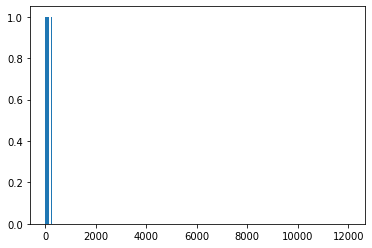

In [496]:
# abs_y_error = np.abs((y_pred - y_test)/y_pred)

# bins = np.linspace(0,1,20)
# plt.bar(abs_y_error, height=1)
# plt.show()

In [529]:
from sklearn.compose import ColumnTransformer

class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.threshold = kwargs.pop('num_std_threshold', 3)
        self.kwargs = kwargs
    def fit(self, X):
        return self
    def transform(self, X):
        return X[(np.abs(stats.zscore(X)) < self.threshold).all(axis=1)]

class CategoricalToDummy(BaseEstimator, TransformerMixin):

    def __init__(self, categorical_columns, drop_one=True, drop_original=True):
        """
        Transforms categorical columns to one-hot-encoded columns named as such:
            '<original column name>_<category name>'

        Args
            categorical_columns: List[str] of categorical columns in X
            drop_one: (bool) when converting to categorical columns, whether to drop the first category name.
                Eg. if a column has categories ['A', 'B'], drop category 'A'. (since 'B' == 1 or 0 is sufficient)
            drop_original: (bool) when transforming categorical columns in X, whether to drop the original columns
        """
        self.categorical_columns = categorical_columns
        self.drop_one = drop_one
        self.drop_original = drop_original

    def fit(self, X, y=None):
        X_temp = X.copy()
        self.dummy_values = {}
        self.base_category_by_col = {}

        for col in self.categorical_columns:
            self.dummy_values[col] = X_temp[col].unique()
            if self.drop_one:
                base_temp = [x for x in self.dummy_values[col] if str(x) != 'nan']
                self.base_category_by_col[col] = base_temp[0]

        return self

    def transform(self, X, y=None):
        X_temp = X.copy()

        for col in self.categorical_columns:
            for cat in self.dummy_values[col]:
                if str(cat) == 'nan':
                    X_temp[str(col) + '_' + str(cat)] = X_temp[col].isnull().astype(int)
                else:
                    X_temp[str(col) + '_' + str(cat)] = (X_temp[col] == cat).astype(int)
            if self.drop_one:
                X_temp.drop(labels=[str(col) + '_' + str(self.base_category_by_col[col])], axis=1, inplace=True)

        if self.drop_original:
            X_temp.drop(labels=self.categorical_columns, axis=1, inplace=True)

        return X_temp

class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List, **kwargs):
        self.columns = columns
        self.kwargs = kwargs
    def fit(self, X):
        self.column_transformer = ColumnTransformer(transformers=[
            ('scaler', StandardScaler(), self.columns)
        ])
        self.column_transformer.fit_transform(X[self.columns])
        return self
    def transform(self, X):
        X_temp = X.copy()
        X_temp[self.columns] = self.column_transformer.transform(X)
        return X_temp

class Splitter(BaseEstimator, TransformerMixin):
    def __init__(self, test_size=0.2, target_col=TARGET_COLUMN):
        self.test_size = test_size
        self.target_col = target_col
    def fit(self, X):
        return self
    def transform(self, X):
        n_test = int(len(X) * self.test_size)
        X_test, y_test = split_feature_target(
            X.sample(n=n_test, random_state=7), self.target_col)
        
        X_train, y_train = split_feature_target(
            X.loc[~X.index.isin(df_test.index)], self.target_col)
        
        return X_train, y_train, X_test, y_test

data_pipeline = Pipeline(steps=[
    ('extract_outliers', OutlierExtractor()),
    ('one_hot_encode', CategoricalToDummy(CATEGORICAL_COLUMNS)),
    ('numeric_scaler', NumericalScaler(FEATURE_COLUMNS)),
    ('split_test_train', Splitter())
])

X_train, y_train, X_test, y_test = data_pipeline.fit_transform(quarterly_df)



9173